In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
sys.path.append(os.path.abspath(r"C:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\PICLab_narrow_linewidth\U_shaped_laser_package\src\u_shaped_lib"))

import RIN as rin

['O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Old_lensed_fiber\\RIN\\2025-04-30_17-53-11-876395esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Old_lensed_fiber\\RIN\\2025-04-30_17-51-13-885399esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Old_lensed_fiber\\RIN\\2025-04-30_17-51-35-530648esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Old_lensed_fiber\\RIN\\2025-04-30_17-49-06-341779esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Old_lensed_fiber\\RIN\\2025-04-30_17-49-47-506047esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Old_lensed_fiber\\RIN\\2025-04-30_17-52-01-475006esa.txt']
[-137.4063588148059, -137.0657935

Text(0.5, 1.0, 'RIN')

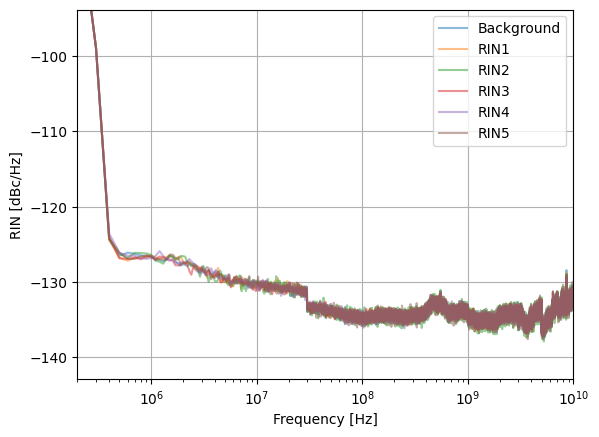

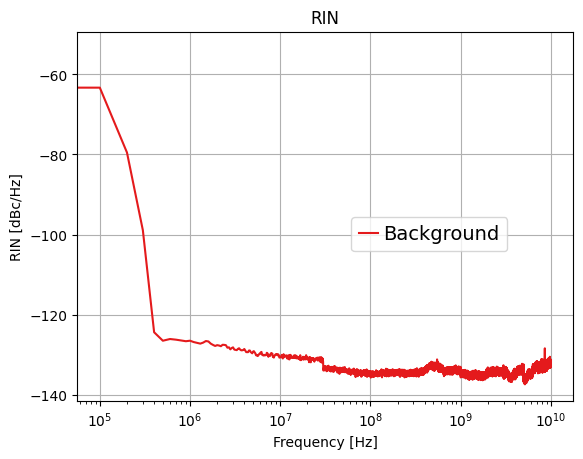

In [4]:
#Old lensed fiber
conversion_factor = rin.calibrate_conversion(power_uW = np.array([581,580,578]),
voltage_mV = np.array([161.89,161.61,161.13]))

data_old = rin.get_RIN_data(directory = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\Weird_data\Old_lensed_fiber\RIN",
conversion_factor = conversion_factor,
background_identifier = '2025-04-30_17-53-11-876395esa',
background_power = 580,
plot = True,
start_idx = 10)

['O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Weird_data_new_params\\RIN\\2025-05-08_15-41-30-687338esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Weird_data_new_params\\RIN\\2025-05-08_15-42-19-715810esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Weird_data_new_params\\RIN\\2025-05-08_15-41-18-656566esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Weird_data_new_params\\RIN\\2025-05-08_15-41-06-674631esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Weird_data_new_params\\RIN\\2025-05-08_15-42-51-446997esa.txt', 'O:\\Tech_Photonics\\Projects\\Narrow Linewidth\\MFB Chips\\Chip 3 Feedback measurements\\Weird_data\\Weird_data_new_params\\RIN\\2025-05-08_15-41-43-403536esa.txt']
[-1

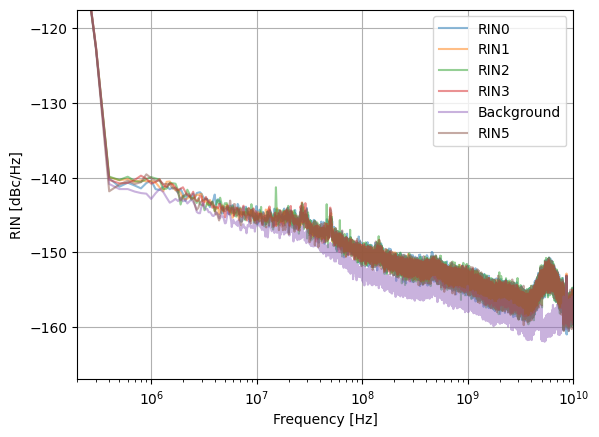

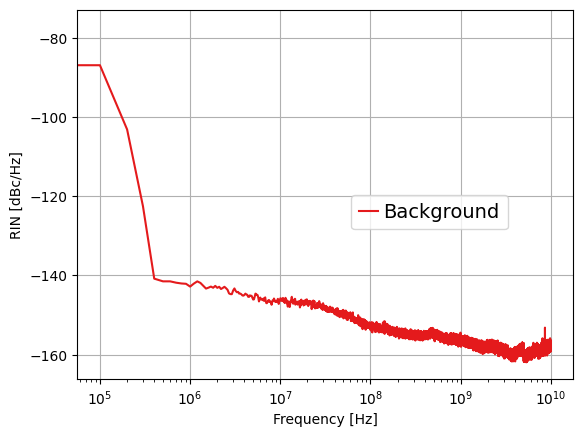

In [ ]:
# New laser params, new lensed fiber

power_uW = np.array([991,991,990,991,989,991])
voltage_mV = np.array([422.23,421.8,421.7,421.67,421.7,422.58])

conversion_factor = rin.calibrate_conversion(power_uW = power_uW,
voltage_mV = voltage_mV)

background_power = np.average(power_uW)

data_new_params =rin.get_RIN_data(directory = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\Weird_data\Weird_data_new_params\RIN",
conversion_factor = conversion_factor,
background_identifier = '2025-05-08_15-42-51-446997esa',
background_power = background_power,
plot = True,
start_idx = 10)